In [1]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import matplotlib.pyplot as plt
from simpleEnv import BatteryEfficientNavEnv
env = BatteryEfficientNavEnv()

# Run episode
def run_episode(env, action_values, render=True):
    obs = env.reset()
    done = False
    
    # Lists to store episode data for plotting
    positions = []
    velocities = []
    rewards = []
    battery_consumptions = []
    
    step = 0
    while not done:
        # Simple policy: higher speed when far from goal, lower speed when closer
        # Reduce force if already moving in right direction
        distance_to_goal = env.max_position - obs[0]
        current_velocity = obs[1]
        desired_force = action_values[step]
        action = np.array([np.clip(desired_force, -env.max_motor_force, env.max_motor_force)])
        
        obs, reward, done, info = env.step(action)
        
        # Store data for plotting
        positions.append(obs[0])
        velocities.append(obs[1])
        rewards.append(reward)
        battery_consumptions.append(info['battery_consumption'])
        step +=1 
    
    return positions, velocities, rewards, battery_consumptions

100%|██████████| 100/100 [00:00<00:00, 142.88it/s]

2688.9953477012614 2296.279555796694


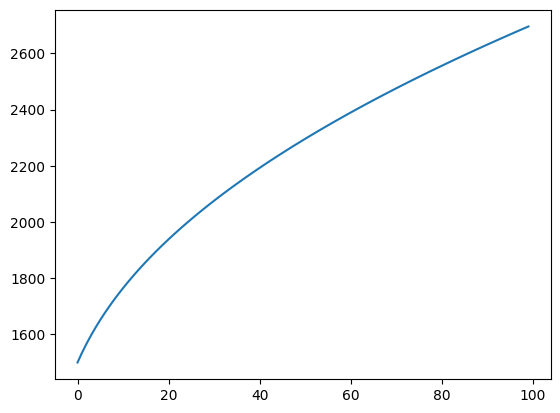

In [2]:
from tqdm import tqdm
env = BatteryEfficientNavEnv()

env.coef_distance_to_goal = 0.002
env.coef_battery_consumption = 0.002
env.coef_efficiency_factor = 0.005
all_results = []
for i in tqdm(np.linspace(0,2.5, 100)):
    action_values = [i/10]*1000
    positions, velocities, rewards, battery_consumptions = run_episode(env, action_values)
    all_results.append((positions, velocities, rewards, battery_consumptions))

rewards = [sum(r[2]) for r in all_results]     
print(rewards[-2], rewards[len(rewards)//2])
plt.plot(rewards)


In [9]:
from tqdm import tqdm
def found_coefs():
    found_coefs = []
    for coef_velocity_efficiency in [np.random.uniform(0.001, 1.0) for _ in range(10)]:
        for coef_battery_consumption in [np.random.uniform(0.001, 1.0) for _ in range(10)]:
            all_results = []
            env.coef_velocity_efficiency = coef_velocity_efficiency
            env.coef_battery_consumption = coef_battery_consumption
            for i in (np.linspace(0, 5.0, 10)):
                action_values = [i/10]*1000
                positions, velocities, rewards, battery_consumptions = run_episode(env, action_values)
                all_results.append((positions, velocities, rewards, battery_consumptions))

            rewards = [sum(r[2]) for r in all_results]                
            if rewards[-1] < rewards[len(rewards)//2]:
                print(f'{coef_velocity_efficiency}, {coef_battery_consumption}')
                found_coefs.append((coef_velocity_efficiency, coef_battery_consumption))
            if len(found_coefs) > 10:
                return found_coefs
    return found_coefs

coefs = found_coefs()


0.11732748693215561, 0.45298524501282944
0.11732748693215561, 0.2746476944109513
0.11732748693215561, 0.6226610513831546
0.11732748693215561, 0.28470591529900807
0.11732748693215561, 0.5092777441405298
0.11732748693215561, 0.2031424057061915
0.11732748693215561, 0.13406370389722425
0.11732748693215561, 0.8600694535509845
0.11732748693215561, 0.6723736645057374
0.21573664193235767, 0.5564857671463883
0.21573664193235767, 0.13580170522220522


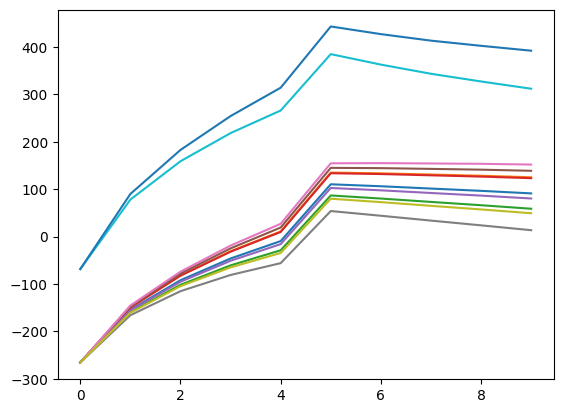

In [11]:
env = BatteryEfficientNavEnv()

for coef_velocity_efficiency, coef_battery_consumption in coefs:    
    env.coef_velocity_efficiency = coef_velocity_efficiency
    env.coef_battery_consumption = coef_battery_consumption
    all_results = []
    for i in np.linspace(0, 5.0, 10):
        action_values = [i/10]*1000
        positions, velocities, rewards, battery_consumptions = run_episode(env, action_values)
        all_results.append((positions, velocities, rewards, battery_consumptions))
    rewards = [sum(r[2]) for r in all_results]                
    assert rewards[-1] < rewards[len(rewards)//2]
    rewards = [sum(r[2]) for r in all_results]     
    plt.plot(rewards)